## Import Necessary Packages

In [1]:
import casadi
import random
import numpy as np
from pytope import Polytope
import matplotlib
import matplotlib.pyplot as plt
import time

from Planner_P import Planner_P
from ModelingSVTrue import ModelingSVTrue

from shapely.geometry import Polygon, Point

%matplotlib inline

In [2]:
# The following is the function to calculate super ellipse
def generate_superellipse_points(a, b, n, num_points):
    
    t_values = np.linspace(0, 2 * np.pi, num_points)
    x_values = a * np.sign(np.cos(t_values)) * np.abs(np.cos(t_values))**(2/n)
    y_values = b * np.sign(np.sin(t_values)) * np.abs(np.sin(t_values))**(2/n)

    return x_values, y_values

## Estimate the Initial Control Set for Proposed Approach

In [3]:
class Initialization_Set_Estimation( ):
    def __init__(self, Params):
        
        self.N_Sam = Params['N_pre_sam']
        self.H     = Params['H']
        self.h     = Params['h']
        self.nv    = Params['nv']
        self.nu    = Params['nu']
        self.LinearProgramming = self.LinearProgramming( )
    
    def Return(self, samples, U_SV_Poly):
        
        theta_initial, y_initial = self.LinearProgramming(samples)
        fW = Polytope(self.H, theta_initial)
        U_hat_initial = fW + y_initial
        
        return theta_initial.full(), y_initial.full(), U_hat_initial
    
    def LinearProgramming(self): 
        H = self.H
        h = self.h
        N_Sam = self.N_Sam
        nv = self.nv
        nu = self.nu
        
        opti = casadi.Opti( )
        
        rho = opti.variable( )
        theta = opti.variable(nv, 1)
        y = opti.variable(nu, 1)
        
        samples = opti.parameter(self.nu, N_Sam)
        
        opti.minimize(rho + np.ones((1, nv))@theta)
        
        for i in range(N_Sam):
            opti.subject_to(-H @ y <= theta - H @ samples[:, i])

        opti.subject_to(H @ y <= 1 - rho)
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho)
            
        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)
        
        return opti.to_function('f', [samples], [theta, y])

## General Parameters

In [4]:
T = 0.2  # time interval
N_EV = 9 # prediction horizon of EV
N_SV = 9 # prediction horizon of SV
v_target_ev = 0.2  # target speed of EV
v_target_sv = 0.3  # target speed of SV
infinity = 1000000 # infinity
l_veh_sv  = 0.36   # vehicle length -- SV
w_veh_sv  = 0.23   # vehicle width  -- SV
l_veh_ev  = 0.26   # vehicle length -- EV
w_veh_ev  = 0.25   # vehicle width  -- EV
DEV  = 4 # dimenstion of EV
DSV  = 4 # dimenstion of SV

# The following is to construct the track
semi_rx = 2.5
semi_ry = 2.5
n = 4
num_points_ev = round((semi_rx + semi_ry)*2/T/v_target_ev) 
num_points_sv = round((semi_rx + semi_ry)*2/T/v_target_sv) 
x_track_ev, y_track_ev   = generate_superellipse_points(semi_rx, semi_ry, n, num_points_ev)
x_track_sv, y_track_sv   = generate_superellipse_points(semi_rx, semi_ry, n, num_points_sv)
x_track_in, y_track_in   = generate_superellipse_points(semi_rx - 0.75, semi_ry - 0.75, n, num_points_ev)
x_track_out, y_track_out = generate_superellipse_points(semi_rx + 0.75, semi_ry + 0.75, n, num_points_sv)

# The following is to define parameters used in the SV modeling
A_SV   = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
B_SV   = np.array([[0.5*T**2, 0], [T, 0], [0, 0.5*T**2], [0, T]])
min_ay = -1
max_ay = 1
min_ax = -1
max_ax = 1
low_bound_control  = (-1, -0.5) # lower bound on ax ay
up_bound_control   = (1, 0.5)   # upper bound on ax ay
x_low = -3.5
y_low = -3.5
x_up  = 3.5
y_up  = 3.5
max_speed = 0.4 # max speed, m/s
X_SV_Poly = Polytope(lb = (x_low, 0, y_low, 0),   ub = (x_up, max_speed, y_up, max_speed)) # state admissible set of SV
U_SV_Poly = Polytope([[0, min_ay], [max_ax, 0], [0, max_ay], [min_ax, 0]])
H = U_SV_Poly.A
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)

for i in range(nv):
    H[i, :] = H[i, :]/h[i]
    h[i] = 1
d_min = np.sqrt((l_veh_ev/2)**2 + (w_veh_ev/2)**2) + np.sqrt((l_veh_sv/2)**2 + (w_veh_sv/2)**2)

## Define Parameter Set for EV and SV Controllers

In [5]:
N_Car = 2
opts_Parameters_EV = { 
    'd_min': d_min,
    'T': T,     
    'N': N_EV,
    'l_f': 0.08,
    'l_r': 0.08,
    'DEV': DEV,
    'N_Car':N_Car,
    'H': H,
    'h': h,
    'nv': nv,
    'nu': nu,
    'A_SV': A_SV,
    'B_SV': B_SV,
    'U_SV_Poly': U_SV_Poly,
    'infinity': infinity,
    'd_min': d_min,
    'Q1': 1, # steering wheel angle
    'Q2': 1, # longitudinal acc
    'Q3': 5, # long. velocity error
    'Q4': 4, # x. pos. error
    'Q5': 4, # y. pos. error
    'v_low': 0, # lower bound of vel.
    'v_up': v_target_ev, # up bound of vel.
    'acc_low': -0.2,  # lower bound of acc.
    'acc_up': 0.2,     # up bound of acc.
    'delta_low': -np.pi/4, # lower bound of front tire angle.
    'delta_up': np.pi/4, # up bound of front tire angle
    'RefSpeed': 0, # terminal reference speed of EV
    'v_target': v_target_ev,
    'x_track': x_track_ev,
    'y_track': y_track_ev,
    'num_points': num_points_ev}

opts_Parameters_SVTrue = { 
    'T': T,     
    'N': N_SV,
    'l_f': 0.14,
    'l_r': 0.14,
    'DSV': 4,
    'v_low': 0, # lower bound of vel.
    'v_up': v_target_sv, # up bound of vel.
    'acc_low': -0.15, # lower bound of acc.
    'acc_up': 0.15,#2.27, # up bound of acc.
    'delta_low': -np.pi/5, # lowver bound of front tire angle.
    'delta_up': np.pi/5, # up bound of front tire angle
    'x_track': x_track_sv,
    'y_track': y_track_sv,
    'v_target': v_target_sv,
    'num_points': num_points_sv,
    'Q1': 1, # steering wheel angle
    'Q2': 1, # longitudinal acceleration
    'Q3': 1, # long. velocity error
    'Q4': 5, # x. pos. error
    'Q5': 5  # y. pos. error
}

## Motion Planning

In [6]:
MotionPlanner =  Planner_P(Params = opts_Parameters_EV)
ModelingSVTrue = ModelingSVTrue(Params = opts_Parameters_SVTrue)

In [7]:
# This section is to obtain the initially estimated control set of the proposed approach
samples_SV = np.array([[-0.0001, -0.0001], [0.0001, -0.0001], [-0.0001, 0.0001], [0.0001, 0.0001]])
samples_SV = samples_SV.reshape(2, 4)
opts_Parameters_Initial_Set_Estimation ={'N_pre_sam': 4, 'H': H, 'h': h,'nv': nv,'nu': nu}
Initialization_Set_Estimation = Initialization_Set_Estimation(Params = opts_Parameters_Initial_Set_Estimation)
theta_initial, y_initial, U_hat_initial = Initialization_Set_Estimation.Return(samples_SV, U_SV_Poly)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [8]:
x_EV_initial = np.array([semi_rx - 1.5, semi_ry, np.pi, 0]) # Initial state of EV
x_SV_initial = np.array([semi_rx, 1, np.pi/2, 0]) # Initial state of SV
Direction_SV = 'clockwise' # moving direction of SV
K_P          = 250 # total simulation steps
# SV
State_SV      = np.zeros((4, K_P + 1)) # state
Control_SV    = np.zeros((2, K_P)) # control
X_SV_Planning = list( ) # planning
# EV
State_EV         = np.zeros((DEV, K_P + 1)) # state
Control_EV       = np.zeros((2, K_P)) # control
J_EV             = np.array([None]*(K_P)) # cost
X_EV_Planning    = list( ) # planning
Aug_Occupancy_SV = list( ) # augmented description of occupancy of SV over prediction horizon
Theta            = list( ) # save the value of alpha_k at very time step
Y                = list( ) # save the value of rho_k at every time step
U_Hat            = list( ) # save the polytope \hat{U}_k at every time step
# initiate
State_SV[:, 0] = x_SV_initial
State_EV[:, 0] = x_EV_initial
Theta.append(theta_initial)
Y.append(y_initial)
U_Hat.append(U_hat_initial)

In [9]:
for k in range(K_P):
    if k == 0:
        u_sv_before = samples_SV[:, -1]
    else:
        u_sv_before = np.array([Control_SV[:, k-1][1]*np.cos(State_SV[:, k-1][2]), Control_SV[:, k-1][1]*np.sin(State_SV[:, k-1][2])])
    print('the step is', k)
    control_SV_k, x_SV_planning_k = ModelingSVTrue.Return(State_SV[:, k], Direction_SV)
    
    U_EV_k, trajectory_planning_EV_k, J_EV_k, Occupancy_SV_aug_k, theta_k, y_k, U_hat_k = MotionPlanner.Return(State_SV[:, k], State_EV[:, k], Theta[-1], Y[-1], u_sv_before)

    Control_SV[:, k] = control_SV_k
    X_SV_Planning.append(x_SV_planning_k)
    State_SV[:, k + 1] = x_SV_planning_k[:, 1]

    X_EV_Planning.append(trajectory_planning_EV_k)
    State_EV[:, k+1] = trajectory_planning_EV_k[:, 1]
    Control_EV[:, k] = U_EV_k
    Aug_Occupancy_SV.append(Occupancy_SV_aug_k)
    Theta.append(theta_k)
    Y.append(y_k)
    U_Hat.append(U_hat_k)
    
    J_EV[k]  = J_EV_k
    
    samples_SV = np.hstack((samples_SV, np.array([Control_SV[:, k][1]*np.cos(State_SV[:, k][2]), Control_SV[:, k][1]*np.sin(State_SV[:, k][2])]).reshape(2, 1)))
print('Done')  
t = np.arange(0, T*(K_P + 1), T, dtype=float) # total simulation time

the step is 0
the step is 1
the step is 2
the step is 3
the step is 4
the step is 5
the step is 6
the step is 7
the step is 8
the step is 9
the step is 10
the step is 11
the step is 12
the step is 13
the step is 14
the step is 15
the step is 16
the step is 17
the step is 18
the step is 19
the step is 20
the step is 21
the step is 22
the step is 23
the step is 24
the step is 25
the step is 26
the step is 27
the step is 28
the step is 29
the step is 30
the step is 31
the step is 32
the step is 33
the step is 34
the step is 35
the step is 36
the step is 37
the step is 38
the step is 39
the step is 40
the step is 41
the step is 42
the step is 43
the step is 44
the step is 45
the step is 46
the step is 47
the step is 48
the step is 49
the step is 50
the step is 51
the step is 52
the step is 53
the step is 54
the step is 55
the step is 56
the step is 57
the step is 58
the step is 59
the step is 60
the step is 61
the step is 62
the step is 63
the step is 64
the step is 65
the step is 66
the s

## Show Global Paths

Text(0, 0.5, 'y [m]')

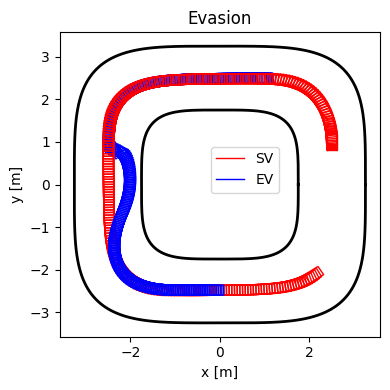

In [15]:
def rota_rect(state, l, w):
    # Visualize the vehicle shape based on pos. and heading
    # Note: the first four states must be x, y, heading, velocity
    
    x       = state[0]
    y       = state[1]
    box     = [(x - l/2, y + w/2), (x + l/2, y + w/2), (x + l/2, y - w/2), (x - l/2, y - w/2)]
    heading = state[2]
    
    box_matrix = np.array(box) - np.repeat(np.array([[x, y]]), len(box), 0)
    theta = -heading
    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    new = box_matrix.dot(rota_matrix) + np.repeat(np.array([[x, y]]), len(box), 0)
    
    x = [new[0][0], new[1][0], new[2][0], new[3][0], new[0][0]]
    y = [new[0][1], new[1][1], new[2][1], new[3][1], new[0][1]]
    return x, y

plt.figure(figsize=(4, 4), tight_layout = True)
for k in range(len(t)):
    
    x_SV, y_SV = rota_rect(State_SV[:, k], l_veh_sv, w_veh_sv)
    x_EV, y_EV = rota_rect(State_EV[:, k], l_veh_sv, w_veh_sv)

    if k == 0:  
        plt.plot(x_SV, y_SV, c='r', linewidth=1, label='SV')
        plt.plot(x_EV, y_EV, c='b', linewidth=1, label='EV')
    else:
        plt.plot(x_SV, y_SV, c='r', linewidth=1)
        plt.plot(x_EV, y_EV, c='b', linewidth=1)      
plt.legend(loc='lower left', bbox_to_anchor=(0.45, 0.45))  
plt.plot(x_track_in, y_track_in, 'k', linewidth=2)
plt.plot(x_track_out, y_track_out, 'k', linewidth=2)
plt.title("Evasion")   
plt.xlabel("x [m]")
plt.ylabel("y [m]")